# Train with oversampling

In [2]:
# Organize data paths and labels
import os
import pandas as pd
from sklearn.model_selection import train_test_split

def resolve_data_path(data_dir: str):
    normal_dir = os.path.join(data_dir, 'NORMAL')
    pneumonia_dir = os.path.join(data_dir, 'PNEUMONIA')

    normal_paths = [os.path.join(data_dir, 'NORMAL', f) for f in os.listdir(normal_dir) if f.endswith(('.jpeg', '.jpg', '.png'))]
    pneumonia_paths = [os.path.join(data_dir, 'PNEUMONIA', f) for f in os.listdir(pneumonia_dir) if f.endswith(('.jpeg', '.jpg', '.png'))]
    pathes = normal_paths + pneumonia_paths
    labels = [0]*len(normal_paths) + [1]*len(pneumonia_paths)
    return pd.DataFrame({'path': pathes, 'label': labels})

# Base dir
# all_df = resolve_data_path("datasets/all_data")
# train_df = resolve_data_path("datasets/train")
# val_df = resolve_data_path("datasets/val")

train_val_df = resolve_data_path("datasets/train_val")
train_df, val_df = train_test_split(train_val_df, test_size=0.2, stratify=train_val_df['label'], random_state=42)

test_df = resolve_data_path("datasets/test")

# train_df, tmp_df = train_test_split(all_df, test_size=0.3, stratify=all_df['label'], random_state=42)
# val_df, test_df = train_test_split(tmp_df, test_size=0.5, stratify=tmp_df['label'], random_state=42)

# compute class weights
class_counts = train_df['label'].value_counts().to_dict()
total_samples = len(train_df)
class_weights = {cls: total_samples/count for cls, count in class_counts.items()}
weights = [class_weights[label] for label in train_df['label']]
# ouptput class weights
print("Class Weights:", class_weights)

print(train_df.head(20))

Class Weights: {1: 1.3473921442369607, 0: 3.8785912882298423}
                                                   path  label
3566  datasets/train_val/PNEUMONIA/person1483_bacter...      1
2866  datasets/train_val/PNEUMONIA/person591_bacteri...      1
2681  datasets/train_val/PNEUMONIA/person361_virus_7...      1
1199  datasets/train_val/NORMAL/NORMAL2-IM-1438-0001...      0
4619  datasets/train_val/PNEUMONIA/person450_bacteri...      1
1008        datasets/train_val/NORMAL/IM-0349-0001.jpeg      0
1295  datasets/train_val/NORMAL/NORMAL2-IM-1261-0001...      0
2688  datasets/train_val/PNEUMONIA/person994_virus_1...      1
3142  datasets/train_val/PNEUMONIA/person1098_bacter...      1
82    datasets/train_val/NORMAL/NORMAL2-IM-0898-0001...      0
4042  datasets/train_val/PNEUMONIA/person67_bacteria...      1
5037  datasets/train_val/PNEUMONIA/person886_virus_1...      1
1980  datasets/train_val/PNEUMONIA/person1617_bacter...      1
4688  datasets/train_val/PNEUMONIA/person333_bacteri... 

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, WeightedRandomSampler, Subset
from torchvision import models
from torchvision.models import ResNet50_Weights, ResNet18_Weights, ResNet34_Weights
from sklearn.metrics import classification_report, roc_auc_score, f1_score, recall_score, confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd
from PIL import Image
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===============================
# 0. CUSTOM DATASET
# ===============================
class ChestXrayDataset(torch.utils.data.Dataset):
    def __init__(self, df: pd.DataFrame, transform=None):
        self.df = df
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['path']
        label = self.df.iloc[idx]['label']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label
    



# ===============================
# 1. METRICS
# ===============================
def compute_metrics(y_true, y_pred, y_prob):
    recall = recall_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp + 1e-8)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    return recall, specificity, f1, auc


# ===============================
# 2. TRAIN / EVAL FUNCTIONS
# ===============================
def train_epoch_binary(model, loader, criterion, optimizer, threshold=0.5):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        
        preds = (torch.sigmoid(outputs) >= threshold).int()
        correct += (preds.cpu() == labels.cpu().int()).sum().item()
        total += labels.size(0)

    return running_loss / len(loader.dataset), correct / total


def eval_epoch_binary(model, loader, criterion, threshold=0.5):
    model.eval()
    running_loss = 0
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            probs = torch.sigmoid(outputs).cpu().numpy().flatten()
            all_probs.extend(probs)
            all_labels.extend(labels.cpu().numpy().flatten())

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)
    preds = (all_probs >= threshold).astype(int)

    return running_loss / len(loader.dataset), preds, all_labels, all_probs


# ===============================
# 3. CROSS-VALIDATION PIPELINE
# ===============================
def cross_validate(df, jitter_ratio, crop_low_bound, val_pre_crop_size, n_splits=5, batch_size=32, lr=1e-4, num_epochs=12, threshold=0.5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_results = []

    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(crop_low_bound, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=jitter_ratio, contrast=jitter_ratio),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_test_transform = transforms.Compose([
        transforms.Resize((val_pre_crop_size, val_pre_crop_size)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['label'])):
        print(f"\n--- Fold {fold+1}/{n_splits} ---")

        train_subset = Subset(ChestXrayDataset(df, transform=train_transform), train_idx)
        val_subset   = Subset(ChestXrayDataset(df, transform=val_test_transform), val_idx)

        # Oversampling sampler
        train_labels = df.iloc[train_idx]['label']
        class_counts = train_labels.value_counts().to_dict()
        total = len(train_labels)
        class_weights = {cls: total/cnt for cls, cnt in class_counts.items()}
        sample_weights = [class_weights[l] for l in train_labels]
        sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

        train_loader = DataLoader(train_subset, batch_size=batch_size, sampler=sampler, num_workers=4)
        val_loader   = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=4)

        # Model, criterion, optimizer
        # model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        model.fc = nn.Linear(model.fc.in_features, 1)
        model.to(device)

        criterion = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        best_balanced = 0

        # setup early stopping
        no_improve_epochs = 0
        max_no_improve = 7

        # Training loop
        for epoch in range(num_epochs):
            train_loss, train_acc = train_epoch_binary(model, train_loader, criterion, optimizer, threshold=threshold)
            val_loss, val_preds, val_trues, val_probs = eval_epoch_binary(model, val_loader, criterion, threshold=threshold)

            recall, spec, f1, auc = compute_metrics(val_trues, val_preds, val_probs)
            balanced = (recall + spec) / 2
            acc = accuracy_score(val_trues, val_preds)

            print(f"Epoch {epoch+1}/{num_epochs} | TrainLoss={train_loss:.4f} | TrainAcc={train_acc:.4f}"
                  f" | ValAcc={acc:.4f} | ValRec={recall:.3f} | ValSpec={spec:.3f} | BalAcc={balanced:.3f} | AUC={auc:.3f}")

            if balanced > best_balanced:
                no_improve_epochs = 0
                best_balanced = balanced
            else:
                no_improve_epochs += 1
                if no_improve_epochs >= max_no_improve:
                    print("Early stopping triggered.")
                    break

        # Evaluate fold
        val_loss, val_preds, val_trues, val_probs = eval_epoch_binary(model, val_loader, criterion)
        recall, spec, f1, auc = compute_metrics(val_trues, val_preds, val_probs)
        fold_results.append({
            "fold": fold+1,
            "recall": recall,
            "specificity": spec,
            "f1": f1,
            "auc": auc
        })

    return fold_results

In [42]:
# ===============================
# 4. RUN CROSS-VALIDATION
# ===============================
best_random_crop_low_bound = 0.0
best_jitter_ratio = 0.0
best_val_pre_crop_size = 0.0

best_accuracy = 0.0

recalls = []
specs = []
accs = []
x_axis = []
for jitter_ratio in [0.2, 0.3]:
    for crop_low_bound in [0.08, 0.3, 0.5]:
        for val_pre_crop_size in [240, 256, 280]:
            
            print(f"\n########## CROSS-VALIDATION with Random Crop Low Bound: {crop_low_bound}, Validation Pre-Crop Size: {val_pre_crop_size}, Jitter ratio: {jitter_ratio} ##########")
            
            x_axis.append(f"jitter_{jitter_ratio}, crop_{crop_low_bound}, val_crop_{val_pre_crop_size}")

            fold_metrics = cross_validate(train_df, jitter_ratio=jitter_ratio, crop_low_bound=crop_low_bound, val_pre_crop_size=val_pre_crop_size, n_splits=5, num_epochs=20, threshold=0.6)
            for fm in fold_metrics:
                print(f"Fold {fm['fold']}: Recall={fm['recall']:.3f}, Spec={fm['specificity']:.3f}, F1={fm['f1']:.3f}, AUC={fm['auc']:.3f}")

            # compute mean and std of fold metrics
            mean_recall = np.mean([fm['recall'] for fm in fold_metrics])
            std_recall = np.std([fm['recall'] for fm in fold_metrics])
            mean_spec = np.mean([fm['specificity'] for fm in fold_metrics])
            std_spec = np.std([fm['specificity'] for fm in fold_metrics])
            mean_f1 = np.mean([fm['f1'] for fm in fold_metrics])
            std_f1 = np.std([fm['f1'] for fm in fold_metrics])
            mean_auc = np.mean([fm['auc'] for fm in fold_metrics])
            std_auc = np.std([fm['auc'] for fm in fold_metrics])

            print(f"\n=== CROSS-VALIDATION SUMMARY ===")
            print(f"Recall     : {mean_recall:.4f} ± {std_recall:.4f}")
            print(f"Specificity: {mean_spec:.4f} ± {std_spec:.4f}")
            print(f"F1 Score   : {mean_f1:.4f} ± {std_f1:.4f}")
            print(f"AUC        : {mean_auc:.4f} ± {std_auc:.4f}")
            print(f"===============================\n")

            recalls.append(mean_recall)
            specs.append(mean_spec)

            accuarcy = (mean_recall + mean_spec) / 2
            accs.append(accuarcy)
            if accuarcy > best_accuracy:
                best_accuracy = accuarcy
                best_pre_crop_size = val_pre_crop_size
                best_jitter_ratio = jitter_ratio
                best_random_crop_low_bound = crop_low_bound


print(f"Best Pre-Crop Size: {best_pre_crop_size}, Jitter Ratio: {best_jitter_ratio}, Random Crop Low Bound: {best_random_crop_low_bound} with Balanced Accuracy: {best_accuracy:.4f}")


########## CROSS-VALIDATION with Random Crop Low Bound: 0.08, Validation Pre-Crop Size: 240, Jitter ratio: 0.2 ##########

--- Fold 1/5 ---
Epoch 1/20 | TrainLoss=0.3154 | TrainAcc=0.8662 | ValAcc=0.9474 | ValRec=0.949 | ValSpec=0.944 | BalAcc=0.946 | AUC=0.988
Epoch 2/20 | TrainLoss=0.2216 | TrainAcc=0.9110 | ValAcc=0.9092 | ValRec=0.879 | ValSpec=0.995 | BalAcc=0.937 | AUC=0.991
Epoch 3/20 | TrainLoss=0.1955 | TrainAcc=0.9256 | ValAcc=0.9522 | ValRec=0.947 | ValSpec=0.967 | BalAcc=0.957 | AUC=0.992
Epoch 4/20 | TrainLoss=0.1943 | TrainAcc=0.9226 | ValAcc=0.9642 | ValRec=0.981 | ValSpec=0.916 | BalAcc=0.948 | AUC=0.992
Epoch 5/20 | TrainLoss=0.1698 | TrainAcc=0.9334 | ValAcc=0.9462 | ValRec=0.929 | ValSpec=0.995 | BalAcc=0.962 | AUC=0.990
Epoch 6/20 | TrainLoss=0.1609 | TrainAcc=0.9370 | ValAcc=0.9247 | ValRec=0.899 | ValSpec=1.000 | BalAcc=0.949 | AUC=0.993
Epoch 7/20 | TrainLoss=0.1531 | TrainAcc=0.9406 | ValAcc=0.9379 | ValRec=0.921 | ValSpec=0.986 | BalAcc=0.954 | AUC=0.989
Epoch


=== ALL CROSS-VALIDATION RESULTS ===


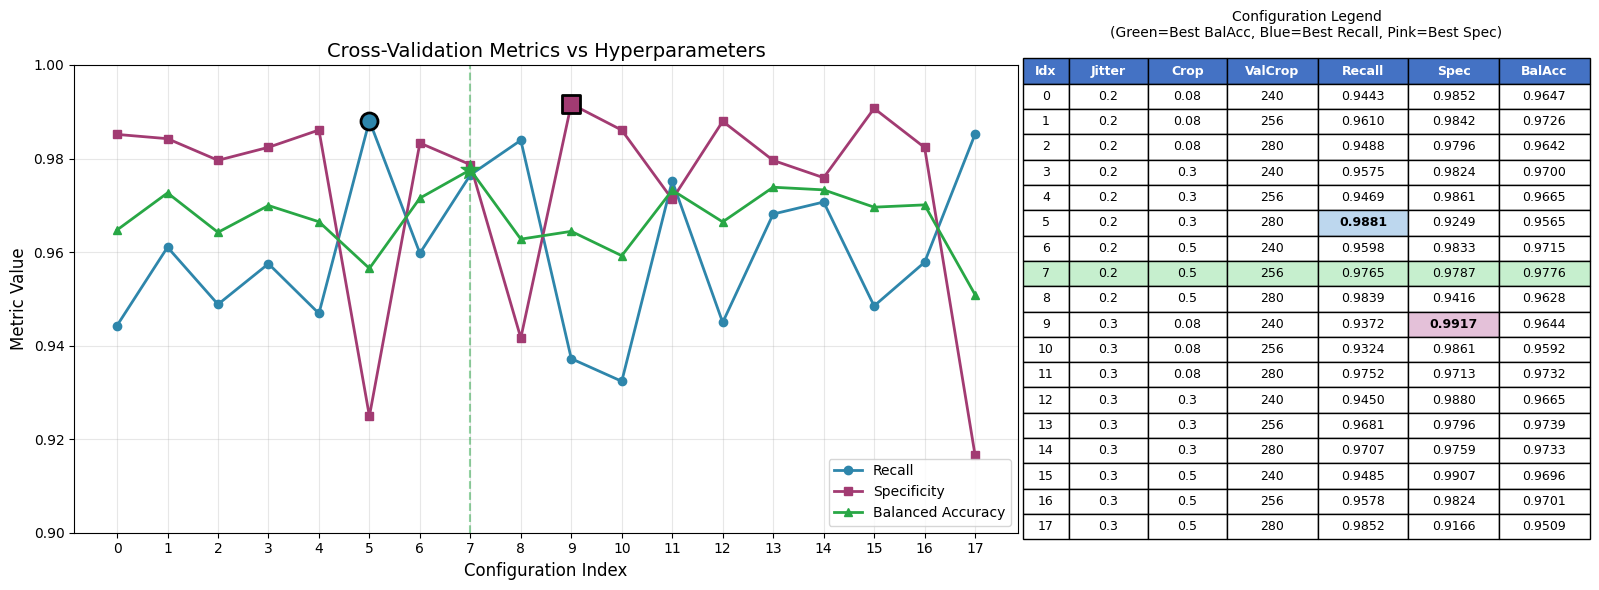

In [134]:
print("\n=== ALL CROSS-VALIDATION RESULTS ===")
from matplotlib import pyplot as plt

# Create figure with two subplots: plot on left, legend table on right
fig, (ax_plot, ax_table) = plt.subplots(1, 2, figsize=(16, 6), 
                                         gridspec_kw={'width_ratios': [2, 1]})

# Plot on the left
indices = range(len(x_axis))
ax_plot.plot(indices, recalls, marker='o', label='Recall', linewidth=2, color='#2E86AB')
ax_plot.plot(indices, specs, marker='s', label='Specificity', linewidth=2, color='#A23B72')
ax_plot.plot(indices, accs, marker='^', label='Balanced Accuracy', linewidth=2, color='#28A745')

ax_plot.set_xlabel('Configuration Index', fontsize=12)
ax_plot.set_ylabel('Metric Value', fontsize=12)
ax_plot.set_title('Cross-Validation Metrics vs Hyperparameters', fontsize=14)
ax_plot.set_xticks(indices)
ax_plot.set_ylim(0.9, 1)
ax_plot.grid(True, alpha=0.3)
ax_plot.legend(loc='lower right')

# Find best indices
best_acc_idx = accs.index(max(accs))
best_recall_idx = recalls.index(max(recalls))
best_spec_idx = specs.index(max(specs))

# Highlight best configurations on plot
ax_plot.axvline(x=best_acc_idx, color='#28A745', linestyle='--', alpha=0.5)
ax_plot.scatter([best_acc_idx], [accs[best_acc_idx]], s=200, c='#28A745', zorder=5, marker='*', label='Best BalAcc')
ax_plot.scatter([best_recall_idx], [recalls[best_recall_idx]], s=150, c='#2E86AB', zorder=5, marker='o', edgecolors='black', linewidths=2)
ax_plot.scatter([best_spec_idx], [specs[best_spec_idx]], s=150, c='#A23B72', zorder=5, marker='s', edgecolors='black', linewidths=2)

# Table on the right
ax_table.axis('off')

# Parse x_axis into table data
table_data = []
for i, config in enumerate(x_axis):
    # Parse: "jitter_0.2, crop_0.08, val_crop_240"
    parts = config.replace('jitter_', '').replace('crop_', '').replace('val_', '').split(', ')
    jitter = parts[0]
    crop = parts[1]
    val_crop = parts[2]
    table_data.append([str(i), jitter, crop, val_crop, f"{recalls[i]:.4f}", f"{specs[i]:.4f}", f"{accs[i]:.4f}"])

# Create table
table = ax_table.table(
    cellText=table_data,
    colLabels=['Idx', 'Jitter', 'Crop', 'ValCrop', 'Recall', 'Spec', 'BalAcc'],
    cellLoc='center',
    loc='center',
    colWidths=[0.08, 0.14, 0.14, 0.16, 0.16, 0.16, 0.16]
)

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.5)

# Color header row
for j in range(7):
    table[(0, j)].set_facecolor('#4472C4')
    table[(0, j)].set_text_props(color='white', fontweight='bold')

# Highlight best rows with respective colors
# Best Balanced Accuracy - Green
for j in range(7):
    table[(best_acc_idx + 1, j)].set_facecolor('#C6EFCE')  # Light green

# Best Recall - Blue (column 4)
table[(best_recall_idx + 1, 4)].set_facecolor('#BDD7EE')  # Light blue
table[(best_recall_idx + 1, 4)].set_text_props(fontweight='bold')

# Best Specificity - Purple/Pink (column 5)
table[(best_spec_idx + 1, 5)].set_facecolor('#E4C1D9')  # Light pink/purple
table[(best_spec_idx + 1, 5)].set_text_props(fontweight='bold')

ax_table.set_title('Configuration Legend\n(Green=Best BalAcc, Blue=Best Recall, Pink=Best Spec)', fontsize=10, pad=20)

plt.tight_layout()
plt.savefig('cv_results.png', dpi=150, bbox_inches='tight')
plt.show()

In [4]:
from torchvision import transforms

best_val_crop = 256
best_jitter = 0.2
best_crop = 0.5

# define transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(best_crop, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=best_jitter, contrast=best_jitter),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((best_val_crop, best_val_crop)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

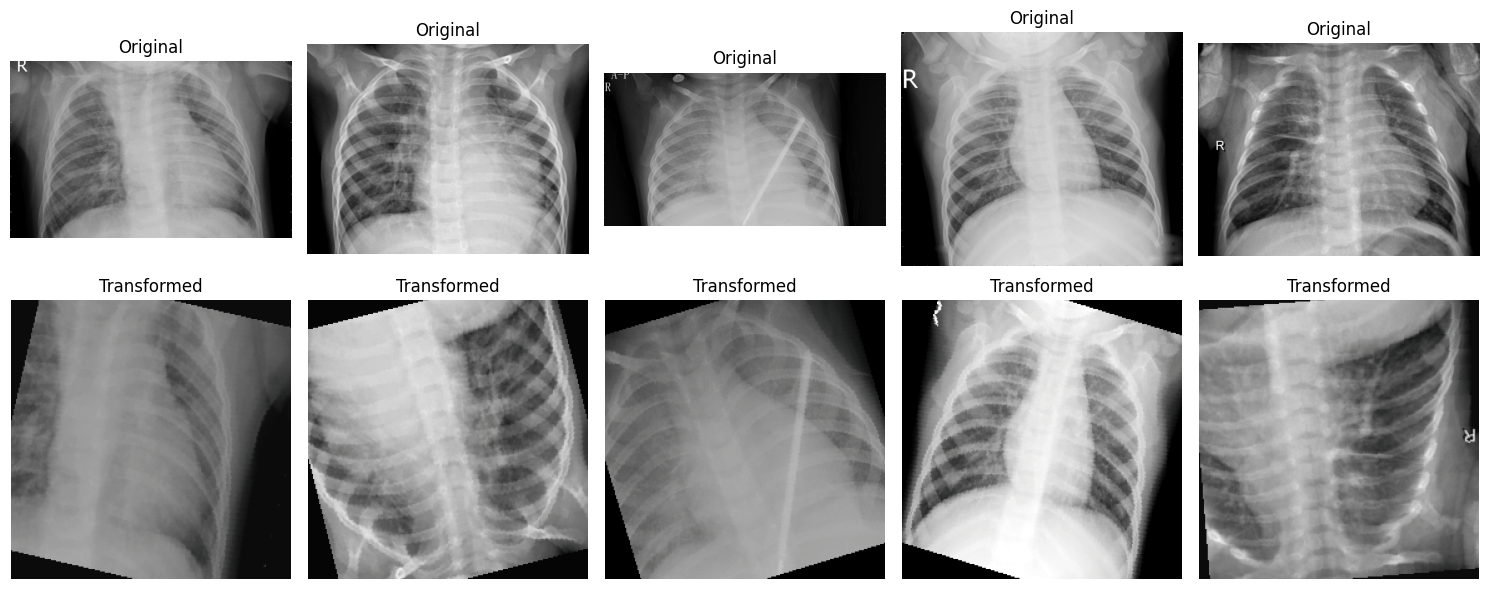

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Define denormalize function
denormalize = transforms.Compose([
    transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    ),
    transforms.ToPILImage()
])

# Now use it to display transformed images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i in range(5):
    img_path = train_df.iloc[i]['path']
    img = Image.open(img_path).convert('RGB')
    
    # Original image
    axes[0, i].imshow(img)
    axes[0, i].set_title("Original")
    axes[0, i].axis('off')
    
    # Transformed image
    transformed = train_transform(img)
    img_display = denormalize(transformed)
    axes[1, i].imshow(img_display)
    axes[1, i].set_title("Transformed")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [6]:
# Init datasets and dataloaders for test set evaluation
# Create dataloaders
best_BC = 64

train_dataset = ChestXrayDataset(train_df, transform=train_transform)
val_dataset = ChestXrayDataset(val_df, transform=val_test_transform)
test_dataset = ChestXrayDataset(test_df, transform=val_test_transform)

# Oversampling sampler
train_labels = train_df['label']
class_counts = train_labels.value_counts().to_dict()
total = len(train_labels)
class_weights = {cls: total/cnt for cls, cnt in class_counts.items()}
sample_weights = [class_weights[l] for l in train_labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=best_BC, sampler=sampler, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=best_BC, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=best_BC, shuffle=False, num_workers=4)


In [193]:
# sechedule learning rate
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import models
from torchvision.models import ResNet18_Weights

# ===============================
# 5. Train FINAL MODEL ON FULL TRAINING SET & EVALUATE ON TEST SET
# ===============================

best_path = "best_bal_model.pth"

best_lr = 1e-4
threshold = 0.6

# Model, criterion, optimizer
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.fc = torch.nn.Linear(model.fc.in_features, 1)  # binary classification
model = model.to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

num_epochs = 50
best_balanced = 0.0
best_auc = 0.0

# set up early stopping
tolorance = 7
no_improve_epochs = 0

train_losses = []
val_losses = []
val_accs = []
val_recalls = []
val_specs = []
val_f1s = []
val_aucs = []

# Training loop
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch_binary(model, train_loader, criterion, optimizer, threshold=threshold)
    val_loss, val_preds, val_trues, val_probs = eval_epoch_binary(model, val_loader, criterion, threshold=threshold)

    scheduler.step(val_loss)
    lr = scheduler.get_last_lr()[0]
    print(f"Epoch {epoch+1}/{num_epochs} | Learning Rate: {lr:.6f}")

    recall, spec, f1, auc = compute_metrics(val_trues, val_preds, val_probs)
    balanced = (recall + spec) / 2
    acc = accuracy_score(val_trues, val_preds)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accs.append(acc)
    val_recalls.append(recall)
    val_specs.append(spec)
    val_f1s.append(f1)
    val_aucs.append(auc)

    print(f"Epoch {epoch+1}/{num_epochs} | TrainLoss={train_loss:.4f} | TrainAcc={train_acc:.4f}"
          f" | ValAcc={acc:.4f} | ValRec={recall:.3f} | ValSpec={spec:.3f} | BalAcc={balanced:.3f} | AUC={auc:.3f}")

    no_improve_epochs += 1
    if balanced > best_balanced:
        best_balanced = balanced
    if auc > best_auc:
        no_improve_epochs = 0
        # best_balanced = balanced
        best_auc = auc
        torch.save(model.state_dict(), best_path)
        print(" --> Saved Best Model")
    if epoch >15 and no_improve_epochs >= tolorance:
        print(f"No improvement for {tolorance} epochs. Early stopping.")
        break

print("\n=== Training Complete ===")

/home/supercomputing/miniconda3/envs/cv/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50 | Learning Rate: 0.000100
Epoch 1/50 | TrainLoss=0.2304 | TrainAcc=0.9004 | ValAcc=0.9542 | ValRec=0.961 | ValSpec=0.933 | BalAcc=0.947 | AUC=0.990
 --> Saved Best Model
Epoch 2/50 | Learning Rate: 0.000100
Epoch 2/50 | TrainLoss=0.1440 | TrainAcc=0.9427 | ValAcc=0.9360 | ValRec=0.923 | ValSpec=0.974 | BalAcc=0.948 | AUC=0.994
 --> Saved Best Model
Epoch 2/50 | Learning Rate: 0.000100
Epoch 2/50 | TrainLoss=0.1440 | TrainAcc=0.9427 | ValAcc=0.9360 | ValRec=0.923 | ValSpec=0.974 | BalAcc=0.948 | AUC=0.994
 --> Saved Best Model
Epoch 3/50 | Learning Rate: 0.000100
Epoch 3/50 | TrainLoss=0.1139 | TrainAcc=0.9582 | ValAcc=0.9542 | ValRec=0.952 | ValSpec=0.959 | BalAcc=0.956 | AUC=0.994
Epoch 3/50 | Learning Rate: 0.000100
Epoch 3/50 | TrainLoss=0.1139 | TrainAcc=0.9582 | ValAcc=0.9542 | ValRec=0.952 | ValSpec=0.959 | BalAcc=0.956 | AUC=0.994
Epoch 4/50 | Learning Rate: 0.000100
Epoch 4/50 | TrainLoss=0.1066 | TrainAcc=0.9601 | ValAcc=0.9427 | ValRec=0.936 | ValSpec=0.963 | BalAc

In [194]:
# Save the last model
torch.save(model.state_dict(), best_path.replace("best","last"))

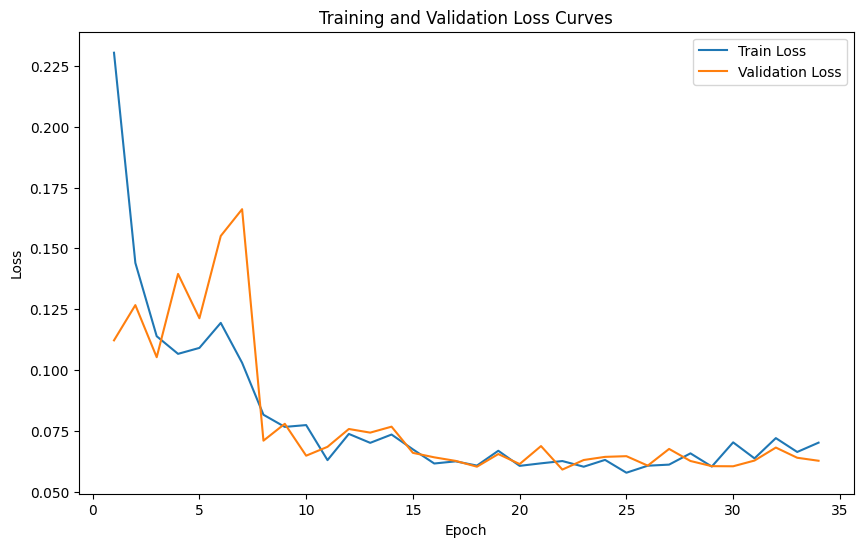

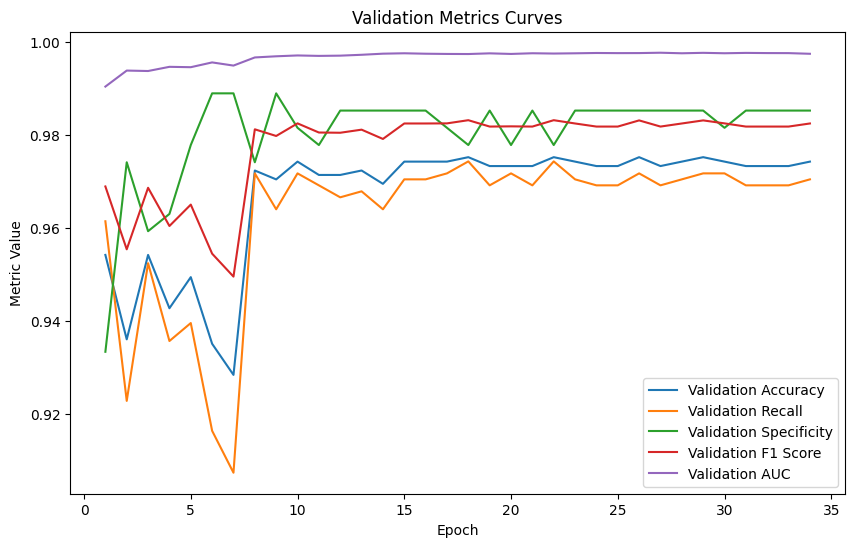

In [195]:
# plot training and validation loss curves
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
run_epochs = len(train_losses)
plt.plot(range(1, run_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, run_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()
# plot validation metrics curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, run_epochs+1), val_accs, label='Validation Accuracy')
plt.plot(range(1, run_epochs+1), val_recalls, label='Validation Recall')
plt.plot(range(1, run_epochs+1), val_specs, label='Validation Specificity')
plt.plot(range(1, run_epochs+1), val_f1s, label='Validation F1 Score')
plt.plot(range(1, run_epochs+1), val_aucs, label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Validation Metrics Curves')
plt.legend()
plt.show()

In [8]:
from torchvision import models
from torchvision.models import ResNet18_Weights
import torch
from sklearn.metrics import classification_report, accuracy_score
from torch import nn

best_path = "best_bal_model.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Loading model from: {best_path}")
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 1)
model.load_state_dict(torch.load(best_path))
model.to(device)

if test_dataset is None:
    test_dataset = ChestXrayDataset(test_df, transform=val_test_transform)
if test_loader is None:
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

criterion = nn.BCEWithLogitsLoss()

print("\n=== Evaluating on Test Set ===")
test_loss, test_preds, test_trues, test_probs = eval_epoch_binary(model, test_loader, criterion, threshold=0.6)
recall, spec, f1, auc = compute_metrics(test_trues, test_preds, test_probs)
acc = accuracy_score(test_trues, test_preds)
print("\n=== FINAL TEST METRICS ===")
print(f"Test Accuracy: {acc:.4f}")
print(f"Recall     : {recall:.4f}")
print(f"Specificity: {spec:.4f}")
print(f"F1 Score   : {f1:.4f}")
print(f"AUC        : {auc:.4f}")

print("\nClassification Report:")
print(classification_report(test_trues, test_preds, target_names=["Normal", "Pneumonia"]))

Loading model from: best_bal_model.pth

=== Evaluating on Test Set ===

=== FINAL TEST METRICS ===
Test Accuracy: 0.9519
Recall     : 0.9923
Specificity: 0.8846
F1 Score   : 0.9627
AUC        : 0.9890

Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      0.88      0.93       234
   Pneumonia       0.93      0.99      0.96       390

    accuracy                           0.95       624
   macro avg       0.96      0.94      0.95       624
weighted avg       0.95      0.95      0.95       624


=== FINAL TEST METRICS ===
Test Accuracy: 0.9519
Recall     : 0.9923
Specificity: 0.8846
F1 Score   : 0.9627
AUC        : 0.9890

Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      0.88      0.93       234
   Pneumonia       0.93      0.99      0.96       390

    accuracy                           0.95       624
   macro avg       0.96      0.94      0.95       624
weighted avg       0.9

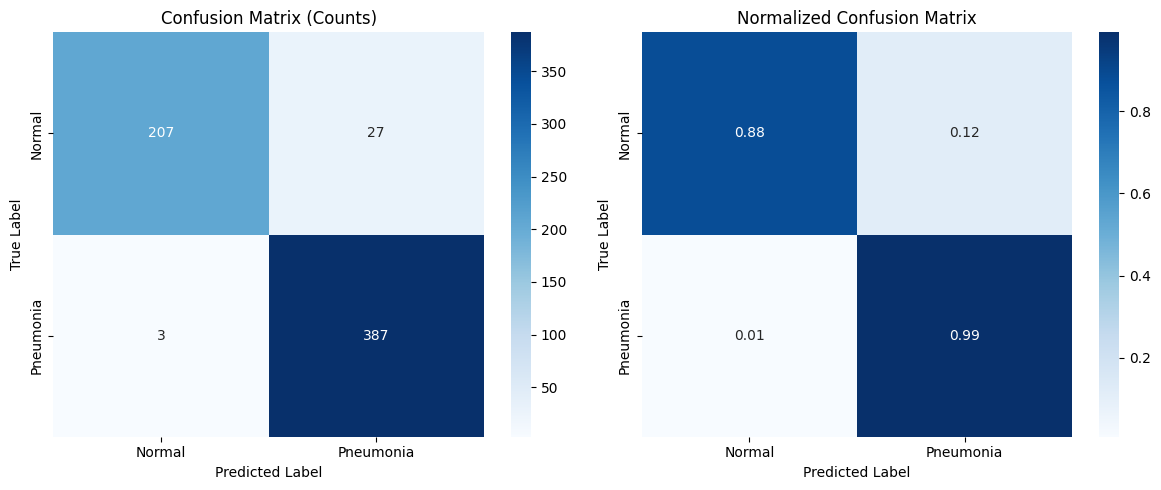

In [9]:
# Plot confusion matrices side by side
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Raw confusion matrix
cm = confusion_matrix(test_trues, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'], ax=axes[0])
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_title('Confusion Matrix (Counts)')

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'], ax=axes[1])
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_title('Normalized Confusion Matrix')

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Explain

In [10]:
def create_path_list(base_path:str, class_name:str):
    path_list = []
    class_path = os.path.join(base_path, class_name.upper())
    files = os.listdir(class_path)
    for _, file in enumerate(files):
        full_path = os.path.join(class_path, file)
        path_list.append(full_path)
    return path_list
class_names = ["Normal", "Pneumonia"]
normal_pathes = create_path_list("datasets/test", class_names[0])
pneumonia_pathes = create_path_list("datasets/test", class_names[1])

## Grad Cam

Visualizing Grad-CAM for Pneumonia case...


/home/supercomputing/miniconda3/envs/cv/lib/python3.13/site-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


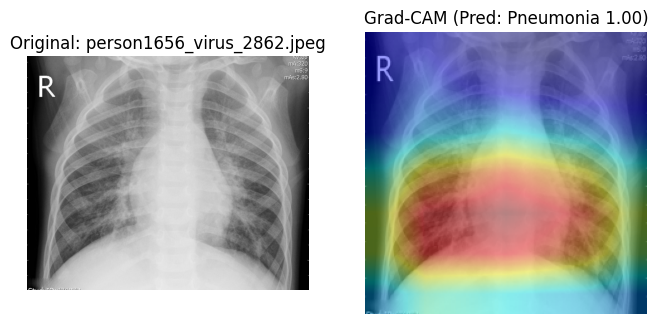

In [11]:
# ============================================================
# GRAD-CAM IMPLEMENTATION
# ============================================================
"""
Grad-CAM: Gradient-weighted Class Activation Mapping
----------------------------------------------------
Unlike CAM which uses fixed weights, Grad-CAM uses the gradients of the target class
flowing into the final convolutional layer to produce a localization map.
This makes it more flexible and applicable to a wider range of CNN architectures.
"""
import cv2
from torch.nn import functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.handles = []
        
        # Register hooks
        self.handles.append(target_layer.register_forward_hook(self.save_activation))
        self.handles.append(target_layer.register_full_backward_hook(self.save_gradient))

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def remove_hooks(self):
        for handle in self.handles:
            handle.remove()
        self.handles = []

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        self.remove_hooks()

    def __call__(self, x):
        # 1. Forward pass
        self.model.zero_grad()
        output = self.model(x)
        
        # 2. Target for backprop
        # For binary classification with 1 output neuron, the output IS the score.
        # We want to explain why the model predicted this value.
        score = output

        # 3. Backward pass to get gradients
        score.backward(retain_graph=True)
        
        # 4. Get gradients and activations
        gradients = self.gradients
        activations = self.activations
        b, k, u, v = activations.size()
        
        # 5. Global Average Pooling of gradients (weights alpha)
        alpha = gradients.view(b, k, -1).mean(2)
        weights = alpha.view(b, k, 1, 1)
        
        # 6. Weighted combination of activations
        saliency_map = (weights * activations).sum(1, keepdim=True)
        
        # 7. ReLU activation (we only care about positive influence)
        saliency_map = F.relu(saliency_map)
        
        # 8. Upsample to input size and normalize
        saliency_map = F.interpolate(saliency_map, size=(224, 224), mode='bilinear', align_corners=False)
        saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
        saliency_map = (saliency_map - saliency_map_min) / (saliency_map_max - saliency_map_min + 1e-8)
        
        return saliency_map.data

# Helper function to visualize Grad-CAM
def visualize_gradcam(img_path, model, layer, class_names, transforms):
    # Ensure model is on the correct device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    # Prepare image
    img_pil = Image.open(img_path).convert('RGB')
    img_tensor = transforms(img_pil).unsqueeze(0).to(device)
    
    # Initialize Grad-CAM with context manager to clean up hooks
    with GradCAM(model, layer) as grad_cam:
        # Generate Heatmap
        mask = grad_cam(img_tensor)
    
    # Overlay
    heatmap = mask.cpu().numpy().squeeze()
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Resize original image to match heatmap
    img_cv = cv2.cvtColor(np.array(img_pil.resize((224, 224))), cv2.COLOR_RGB2BGR)
    
    # Superimpose
    superimposed_img = heatmap * 0.4 + img_cv * 0.6
    superimposed_img = np.uint8(superimposed_img)
    
    # Get prediction for title
    with torch.no_grad():
        logit = model(img_tensor)
        prob = torch.sigmoid(logit).item()
        pred_idx = 1 if prob >= 0.6 else 0
        pred_class = class_names[pred_idx]
    
    # Plot
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_pil)
    plt.title(f"Original: {os.path.basename(img_path)}")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Grad-CAM (Pred: {pred_class} {prob:.2f})")
    plt.axis('off')
    plt.show()

# Run Grad-CAM on a sample
print("Visualizing Grad-CAM for Pneumonia case...")
target_layer = model.layer4[-1] # Last residual block of ResNet18
visualize_gradcam(pneumonia_pathes[1], model, target_layer, class_names, val_test_transform)

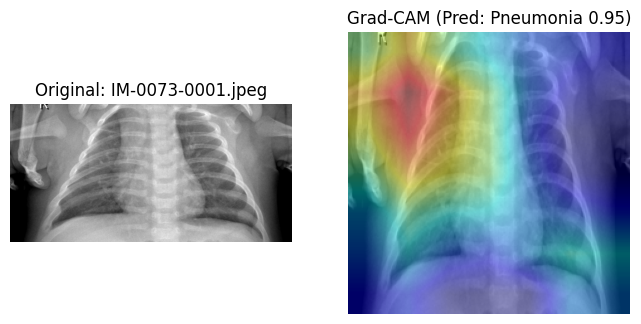

In [12]:
visualize_gradcam(normal_pathes[1], model, target_layer, class_names, val_test_transform)

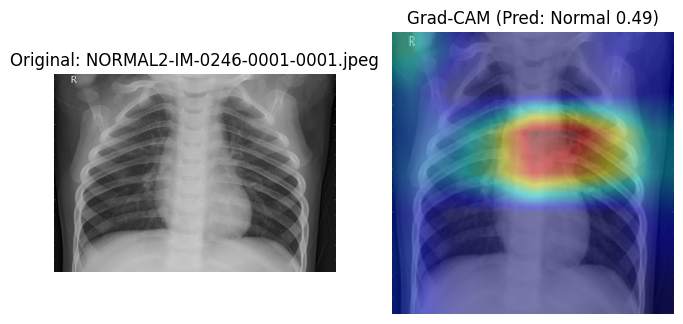

In [32]:
visualize_gradcam(normal_pathes[0], model, target_layer, class_names, val_test_transform)

## LIME
Local Interpretable Model-agnostic Explanations (LIME) is about explaining what machine learning classifiers (or models) are doing. As the name suggests, the method is model-agnostic, meaning that it can be used without modifying the trained model itself to explain any black box classifier with two or more classes. Also, the methode produces local explainability, meaning that the method produces explainability for the classification of a single image as the model may be very complex globally. Therefore, it is easier to approximate it around the vicinity of a particular instance. For this, the method produces an array of images from an original input image by using a pertubation algorithm. The method only requires that the classifier implements a function that takes in raw text or a numpy array and outputs a probability for each class. Consequently, two things must be provided to the LIME package to make it work:
1. Original image as numpy array or tensor and
2. A classification function that would take array of purturbed images as input and produce the probabilities for each class for each image as output.

Let us first define the functions for image preprocessing.

In [43]:
# ============================================================
# LIME IMPLEMENTATION
# ============================================================
from lime import lime_image
from skimage.segmentation import mark_boundaries

class LimeExplainer:
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.explainer = lime_image.LimeImageExplainer(random_state=42)

    def predict_fn(self, images):
        """
        LIME requires a prediction function that takes a numpy array of images
        and returns prediction probabilities.
        """
        self.model.eval()
        # images is (N, H, W, C) numpy array of transformed (normalized) data
        # Convert to (N, C, H, W) tensor
        batch = torch.tensor(images).permute(0, 3, 1, 2).float().to(self.device)
        # normalization
        normalize = transforms.Compose([
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        batch = normalize(batch)

        
        with torch.no_grad():
            logits = self.model(batch)
            probs = torch.sigmoid(logits)
            # LIME expects [N, num_classes]
            # For binary, we construct [prob_0, prob_1]
            probs_1 = probs.cpu().numpy().reshape(-1, 1)
            probs_0 = 1 - probs_1
            return np.hstack((probs_0, probs_1))

    def explain(self, image, num_samples=1000, num_features=5):
        # img_tensor is (C, H, W)
        # Convert to (H, W, C) numpy for LIME
        img_np = image.permute(1, 2, 0).cpu().numpy()
        
        explanation = self.explainer.explain_instance(
            img_np, 
            self.predict_fn, 
            top_labels=1, 
            hide_color=0, 
            num_samples=num_samples,
            num_features=num_features
        )
        return explanation

def visualize_lime(img_path, explainer, class_names, num_features=5):
    img_pil = Image.open(img_path).convert('RGB')
    # preprocess
    pre_process = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])
    img_pil = pre_process(img_pil)
    explanation = explainer.explain(img_pil, num_features=num_features)
    label = explanation.top_labels[0]
    
    img_display = img_pil/255.0  # for display
    
    # Get mask for positive features (Green)
    _, pos_mask = explanation.get_image_and_mask(
        label, 
        positive_only=True, 
        num_features=num_features, 
        hide_rest=False
    )
    
    # Get mask for all top features (Positive + Negative)
    _, all_mask = explanation.get_image_and_mask(
        label, 
        positive_only=False, 
        num_features=num_features, 
        hide_rest=False
    )
    
    # Calculate negative mask (Red)
    # Pixels that are in all_mask but NOT in pos_mask are negative
    neg_mask = (all_mask == 1) & (pos_mask == 0)
    
    # Create boundary image
    img_boundary = img_display.copy()
    
    # Apply positive boundaries (Green)
    if np.any(pos_mask):
        img_boundary = mark_boundaries(img_boundary, pos_mask, color=(0, 1, 0))
        
    # Apply negative boundaries (Red)
    if np.any(neg_mask):
        img_boundary = mark_boundaries(img_boundary, neg_mask, color=(1, 0, 0))
    
    # Get prediction
    probs = explainer.predict_fn(img_pil)[0]
    prob = probs[label]
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_display)
    plt.title(f"Original: {os.path.basename(img_path)}")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(img_boundary)
    plt.title(f"LIME: {class_names[label]} ({prob:.2f})\n(Green=Pos, Red=Neg)")
    plt.axis('off')
    plt.show()

# Initialize LIME
lime_wrapper = LimeExplainer(model, device)
print("LIME Explainer initialized!")

LIME Explainer initialized!


In [44]:
# Run LIME on a Pneumonia sample
print("Visualizing LIME for Pneumonia case...")
visualize_lime(pneumonia_pathes[1], lime_wrapper, class_names, val_test_transform)

Visualizing LIME for Pneumonia case...


AttributeError: 'Image' object has no attribute 'permute'

  0%|          | 0/1000 [00:00<?, ?it/s]

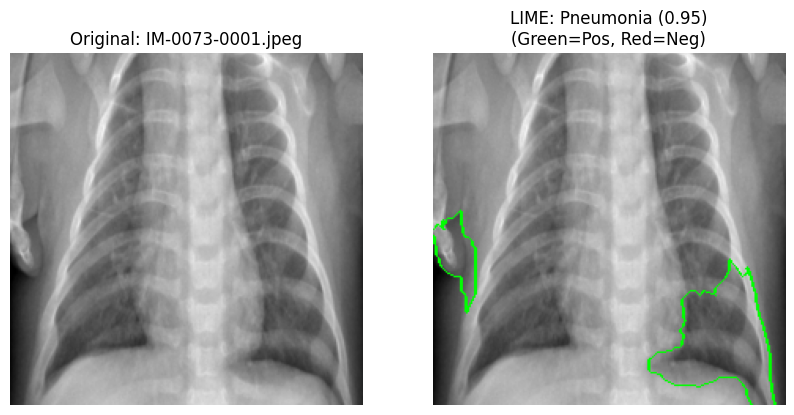

In [37]:
visualize_lime(normal_pathes[1], lime_wrapper, class_names, val_test_transform)

# Comparsion

Comparing Grad-CAM and LIME for Pneumonia case...


  0%|          | 0/1000 [00:00<?, ?it/s]

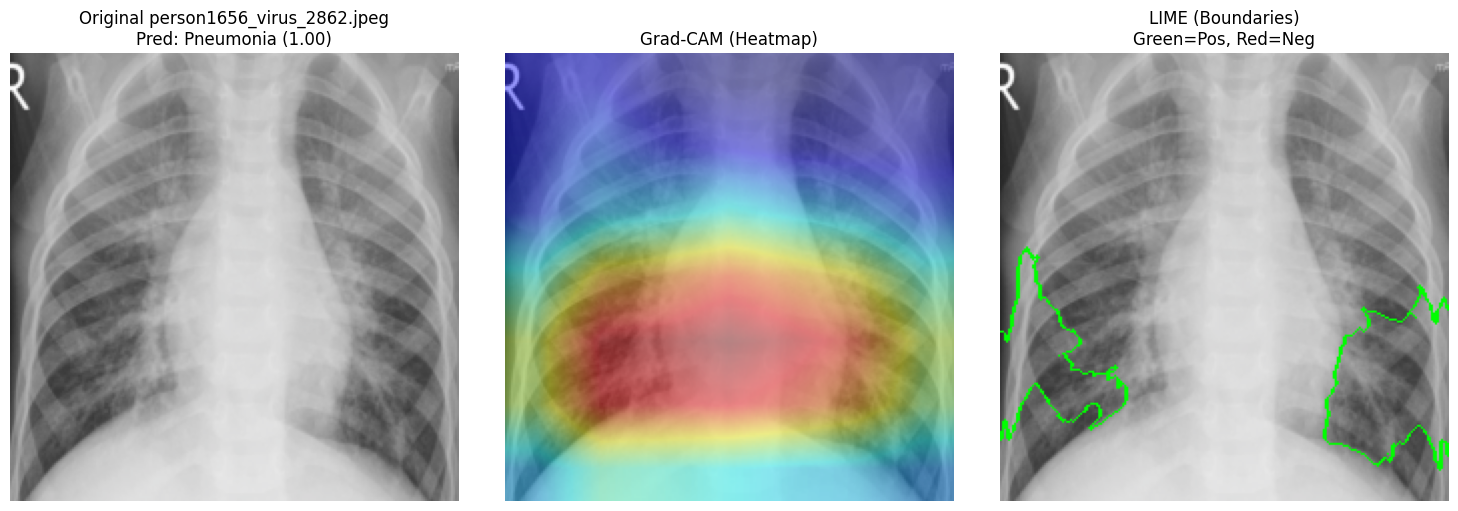


Comparing Grad-CAM and LIME for Normal case...


  0%|          | 0/1000 [00:00<?, ?it/s]

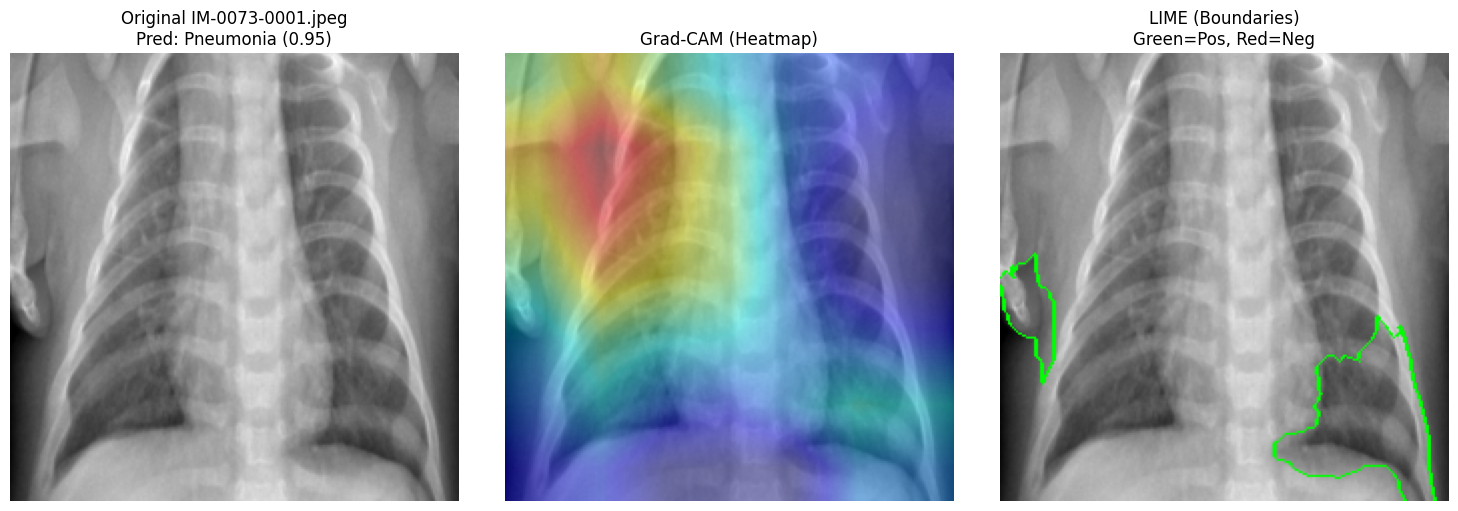


Comparing Grad-CAM and LIME for Normal case...


  0%|          | 0/1000 [00:00<?, ?it/s]

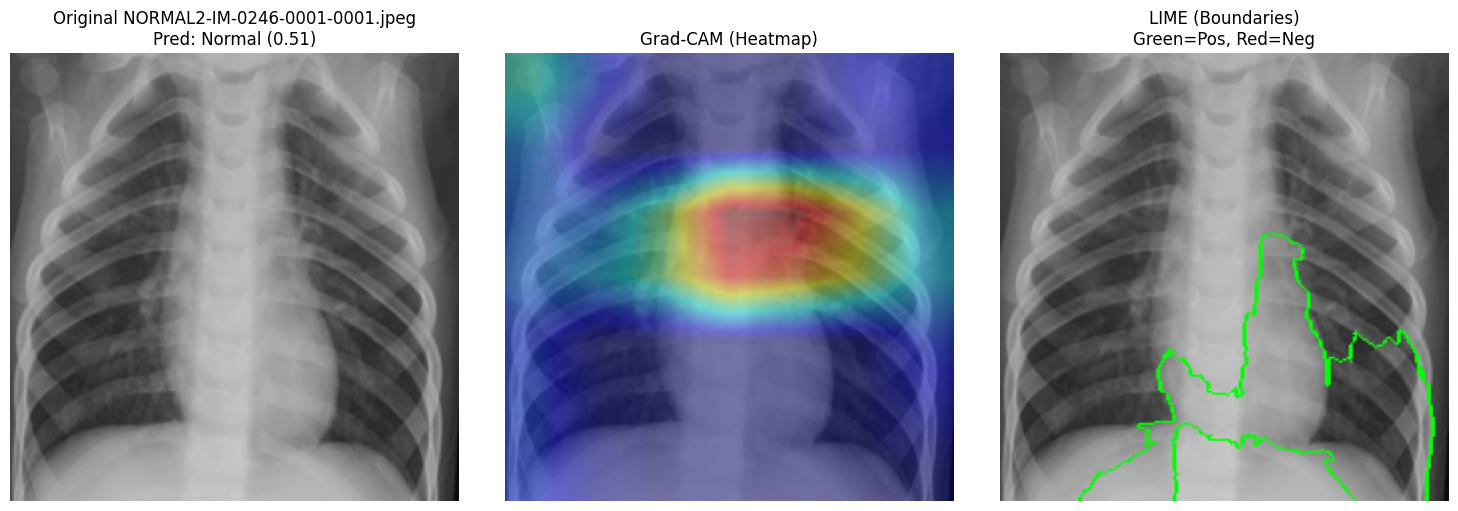

In [41]:
def compare_xai_methods(img_path, model, target_layer, lime_explainer, class_names, transform, num_features=5):
    # Ensure model is in eval mode
    model.eval()
    
    # 1. Prepare Data
    img_pil = Image.open(img_path).convert('RGB')
    # Transform for model input (batch size 1)
    img_tensor = transform(img_pil).unsqueeze(0).to(device)
    
    # Denormalize for visualization (This ensures we see exactly what the model saw)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_np = img_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    img_display = std * img_np + mean
    img_display = np.clip(img_display, 0, 1)
    img_uint8 = np.uint8(255 * img_display) # For OpenCV
    
    # Get Prediction
    with torch.no_grad():
        logits = model(img_tensor)
        prob = torch.sigmoid(logits).item()
        pred_idx = 1 if prob >= 0.6 else 0
        pred_class = class_names[pred_idx]

    # ===========================
    # 2. Run Grad-CAM
    # ===========================
    with GradCAM(model, target_layer) as grad_cam:
        mask = grad_cam(img_tensor)
    
    # Process Grad-CAM result
    heatmap = mask.cpu().numpy().squeeze()
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Use the denormalized image for overlay to ensure alignment
    img_cv = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2BGR)
    gradcam_img = heatmap * 0.4 + img_cv * 0.6
    gradcam_img = np.uint8(gradcam_img)
    gradcam_img = cv2.cvtColor(gradcam_img, cv2.COLOR_BGR2RGB)

    # ===========================
    # 3. Run LIME
    # ===========================
    # LIME expects (C, H, W) tensor for the updated explain method
    # We reuse the already transformed img_tensor (squeezed)
    lime_tensor = img_tensor.squeeze()
    explanation = lime_explainer.explain(lime_tensor, num_features=num_features)
    label = explanation.top_labels[0]
    
    # Process LIME result
    _, pos_mask = explanation.get_image_and_mask(label, positive_only=True, num_features=num_features, hide_rest=False)
    _, all_mask = explanation.get_image_and_mask(label, positive_only=False, num_features=num_features, hide_rest=False)
    neg_mask = (all_mask == 1) & (pos_mask == 0)
    
    lime_img = img_display.copy()
    if np.any(pos_mask):
        lime_img = mark_boundaries(lime_img, pos_mask, color=(0, 1, 0))
    if np.any(neg_mask):
        lime_img = mark_boundaries(lime_img, neg_mask, color=(1, 0, 0))
    
    if pred_idx != label:
        print(f"Warning: LIME top label {class_names[label]} does not match model prediction {pred_class}.")

    if pred_idx == 0:
        prob = 1 - prob  # Adjust probability for Normal class

    # ===========================
    # 4. Plot Comparison
    # ===========================
    plt.figure(figsize=(15, 5))
    
    # Original (Denormalized)
    plt.subplot(1, 3, 1)
    plt.imshow(img_display)
    plt.title(f"Original {os.path.basename(img_path)}\nPred: {pred_class} ({prob:.2f})")
    plt.axis('off')
    
    # Grad-CAM
    plt.subplot(1, 3, 2)
    plt.imshow(gradcam_img)
    plt.title("Grad-CAM (Heatmap)")
    plt.axis('off')
    
    # LIME
    plt.subplot(1, 3, 3)
    plt.imshow(lime_img)
    plt.title(f"LIME (Boundaries)\nGreen=Pos, Red=Neg")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Run Comparison
print("Comparing Grad-CAM and LIME for Pneumonia case...")
compare_xai_methods(pneumonia_pathes[1], model, target_layer, lime_wrapper, class_names, val_test_transform)

print("\nComparing Grad-CAM and LIME for Normal case...")
compare_xai_methods(normal_pathes[1], model, target_layer, lime_wrapper, class_names, val_test_transform)

print("\nComparing Grad-CAM and LIME for Normal case...")
compare_xai_methods(normal_pathes[0], model, target_layer, lime_wrapper, class_names, val_test_transform)

In [29]:
# Get random 5 normal and 5 pneumonia images from test set for XAI comparison
import random
random.seed(42)
sampled_normal = random.sample(normal_pathes, 5)
sampled_pneumonia = random.sample(pneumonia_pathes, 5)

Comparing Grad-CAM and LIME for Normal case: NORMAL2-IM-0282-0001.jpeg


  0%|          | 0/2000 [00:00<?, ?it/s]

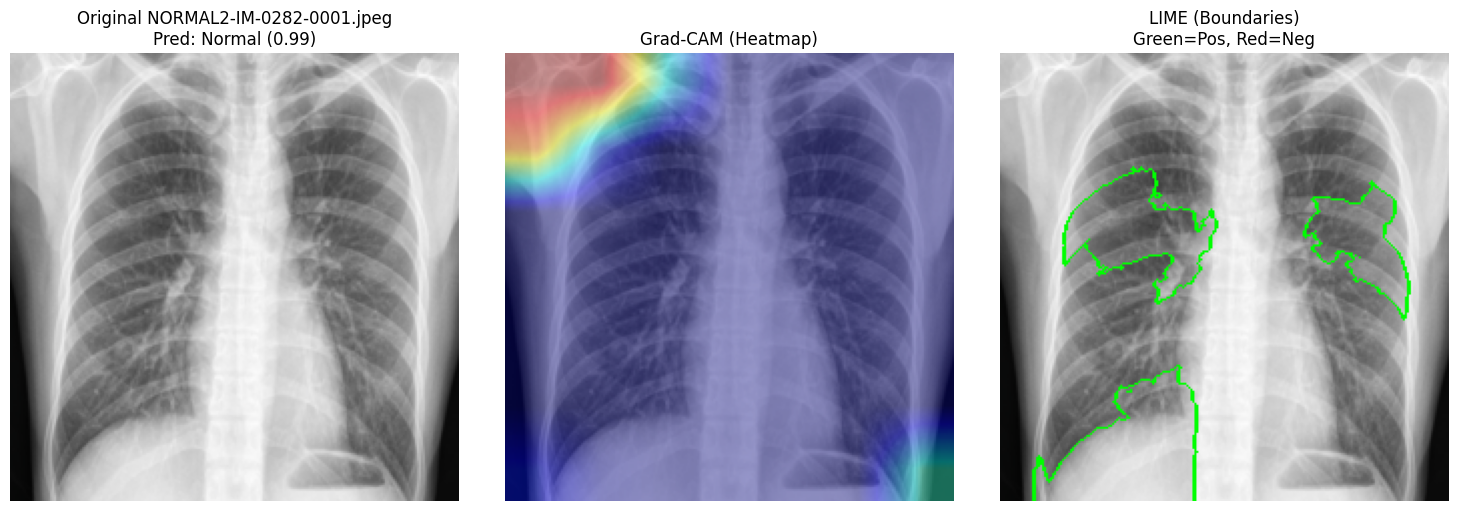

Comparing Grad-CAM and LIME for Normal case: NORMAL2-IM-0312-0001.jpeg


  0%|          | 0/2000 [00:00<?, ?it/s]

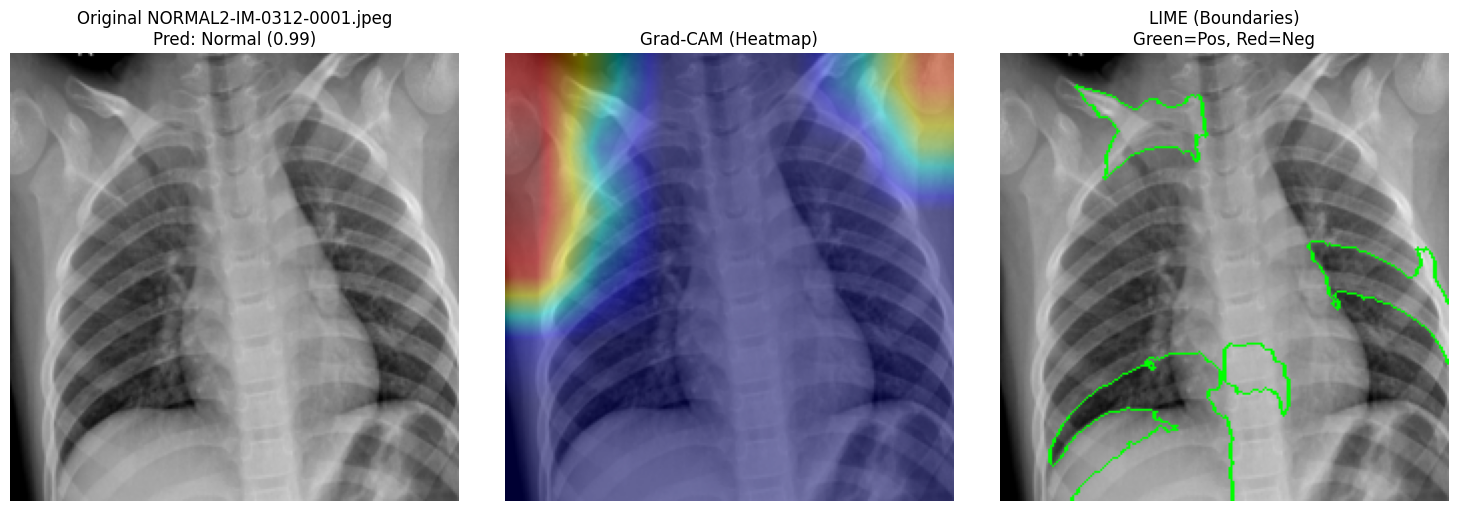

Comparing Grad-CAM and LIME for Normal case: NORMAL2-IM-0280-0001.jpeg


  0%|          | 0/2000 [00:00<?, ?it/s]

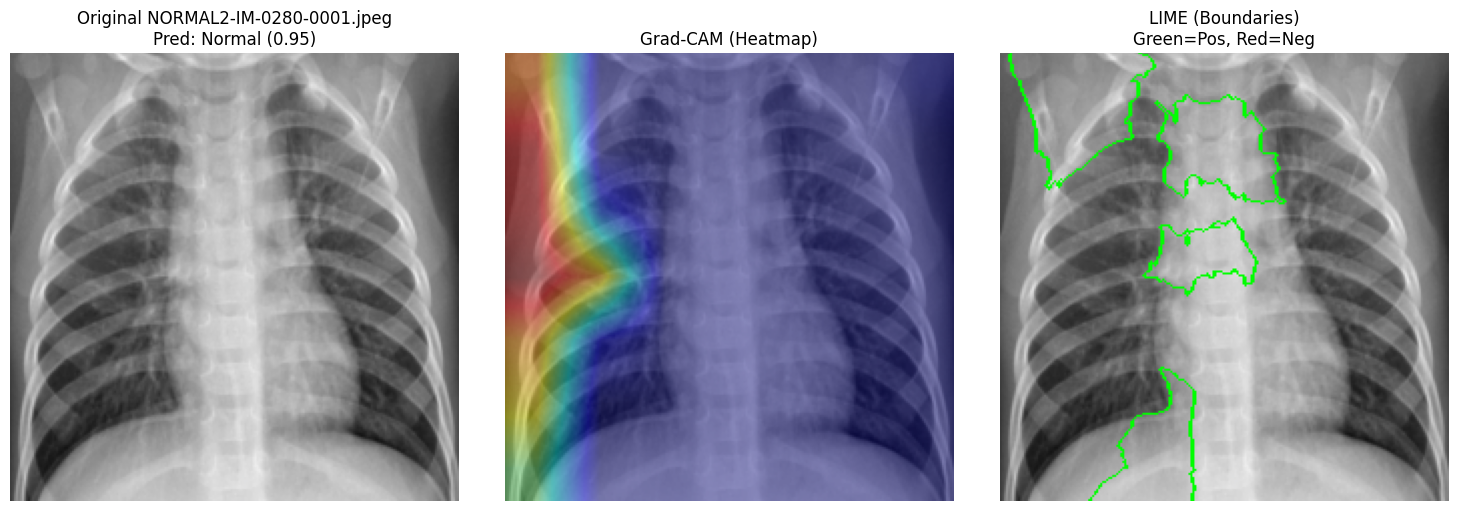

Comparing Grad-CAM and LIME for Normal case: NORMAL2-IM-0035-0001.jpeg


  0%|          | 0/2000 [00:00<?, ?it/s]

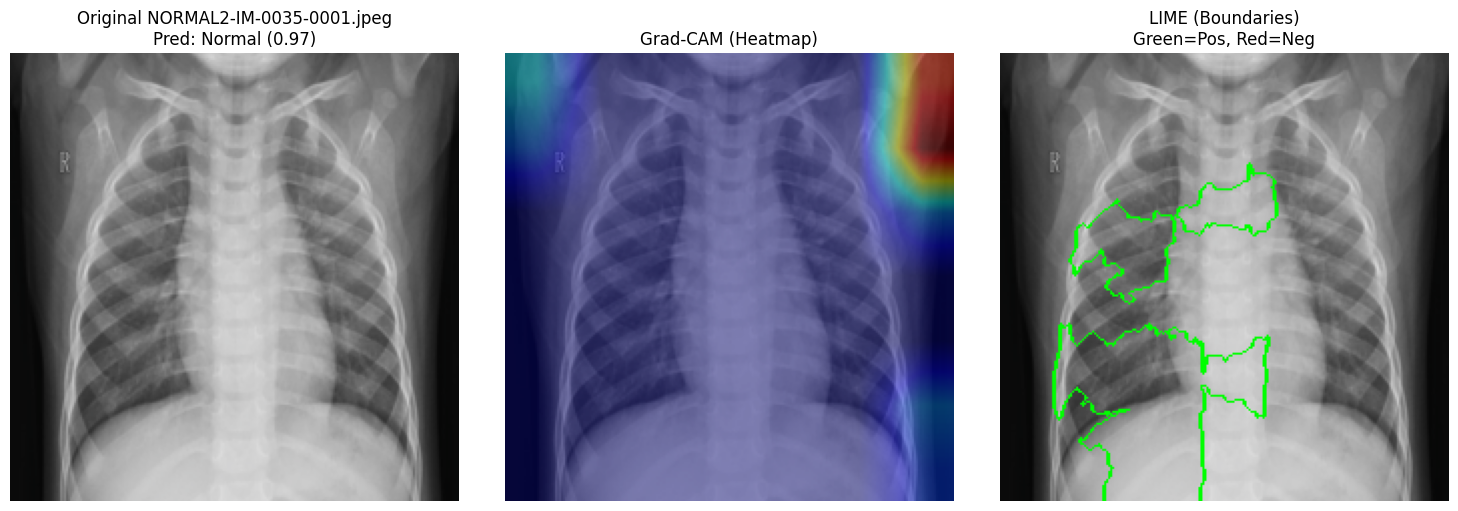

Comparing Grad-CAM and LIME for Normal case: IM-0003-0001.jpeg


  0%|          | 0/2000 [00:00<?, ?it/s]

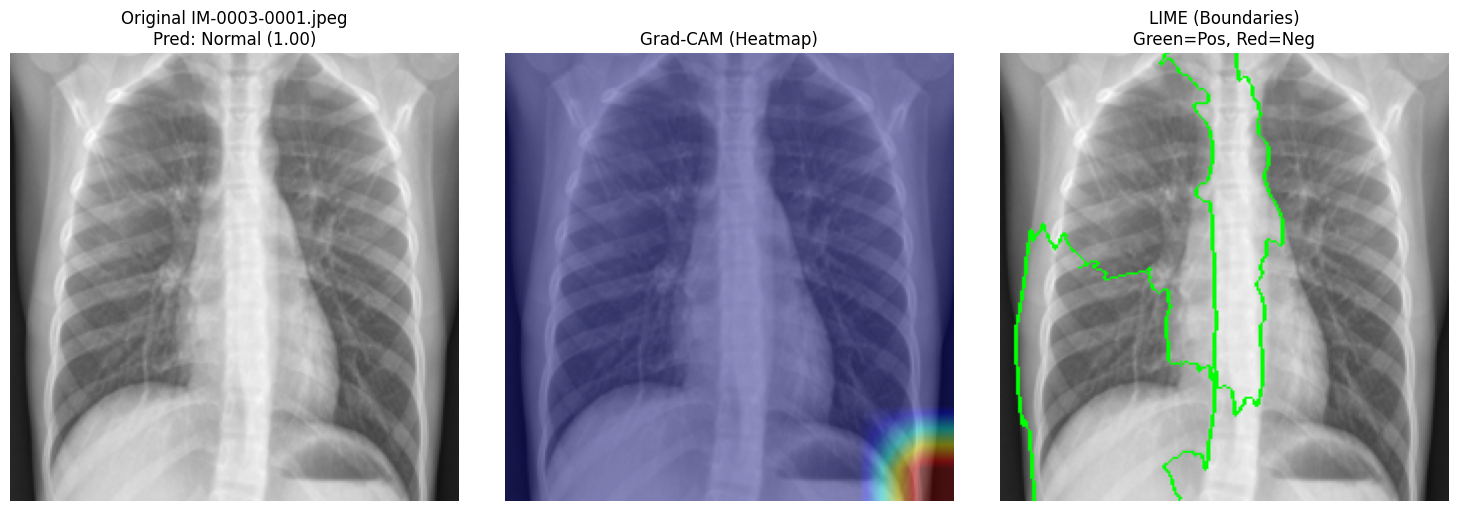

In [30]:
# normal case
for img_path in sampled_normal:
    print(f"Comparing Grad-CAM and LIME for Normal case: {os.path.basename(img_path)}")
    compare_xai_methods(img_path, model, target_layer, lime_wrapper, class_names, val_test_transform)

Comparing Grad-CAM and LIME for Pneumonia case: person133_bacteria_638.jpeg


  0%|          | 0/1000 [00:00<?, ?it/s]

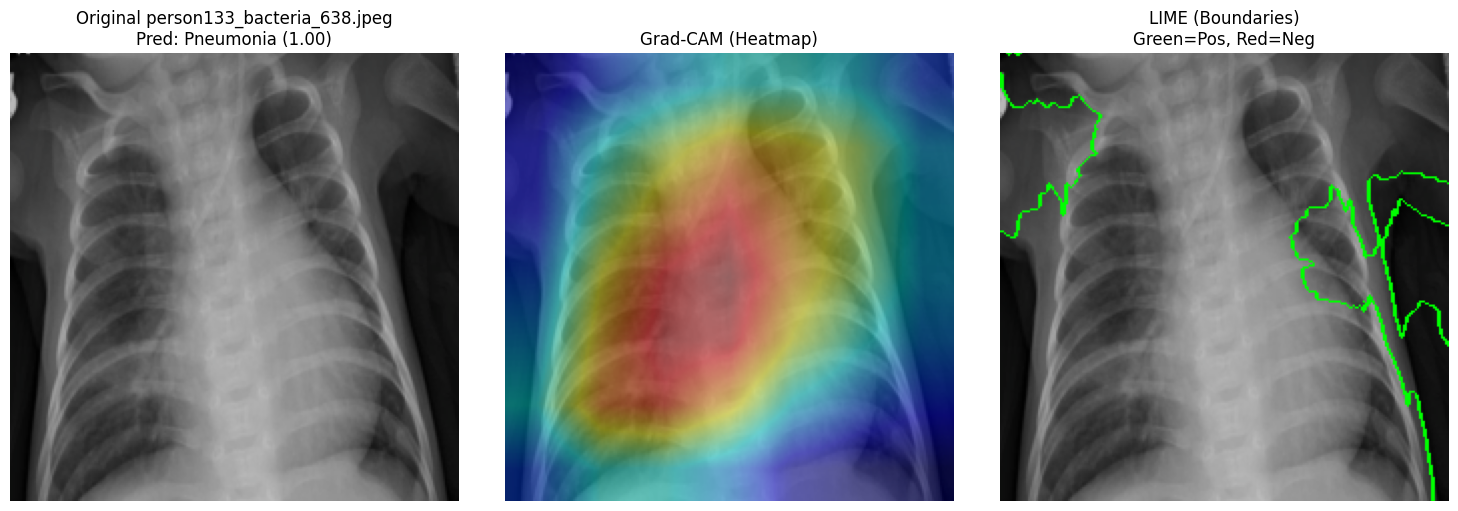

Comparing Grad-CAM and LIME for Pneumonia case: person134_bacteria_644.jpeg


  0%|          | 0/1000 [00:00<?, ?it/s]

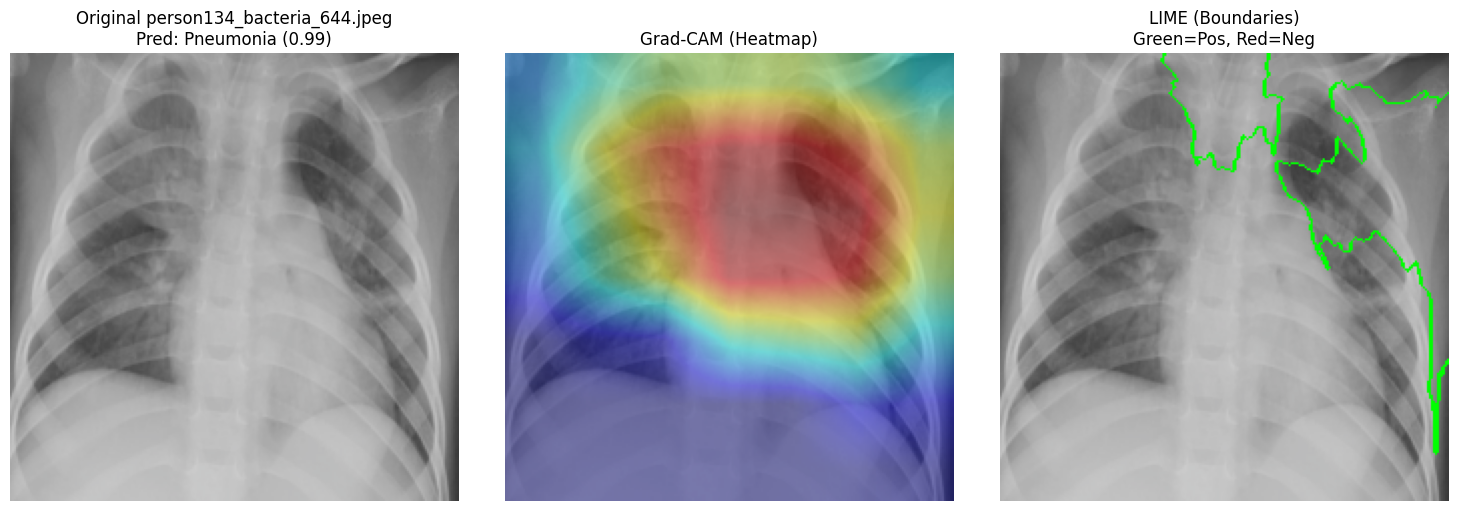

Comparing Grad-CAM and LIME for Pneumonia case: person1608_virus_2786.jpeg


  0%|          | 0/1000 [00:00<?, ?it/s]

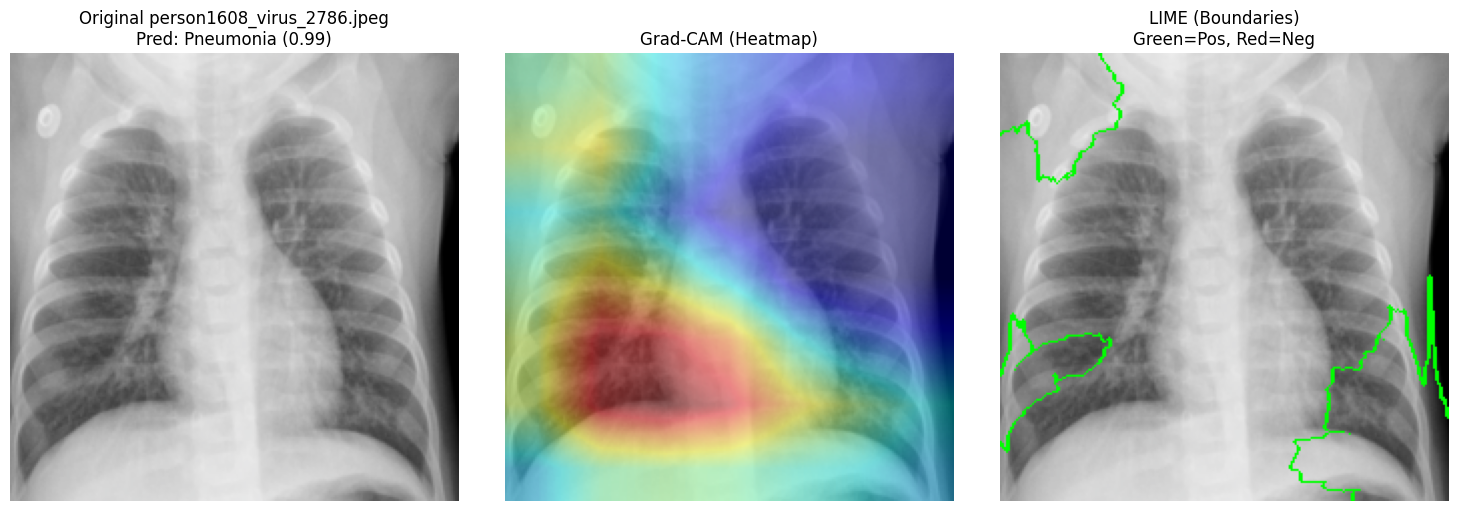

Comparing Grad-CAM and LIME for Pneumonia case: person1676_virus_2892.jpeg


  0%|          | 0/1000 [00:00<?, ?it/s]

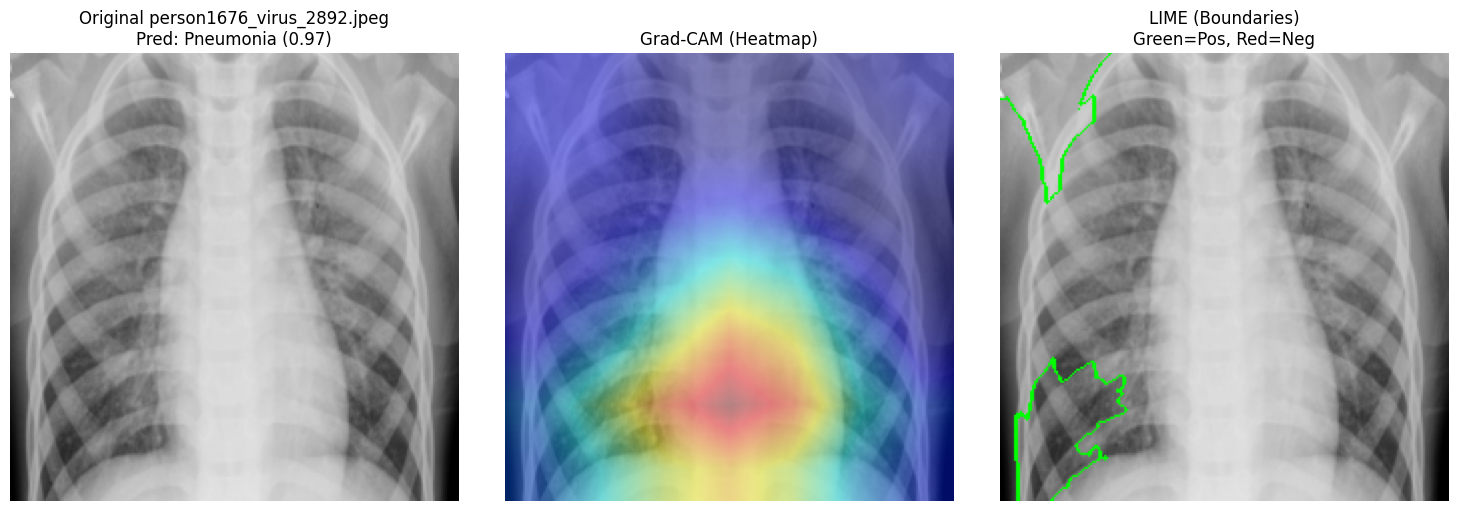

Comparing Grad-CAM and LIME for Pneumonia case: person117_bacteria_556.jpeg


  0%|          | 0/1000 [00:00<?, ?it/s]

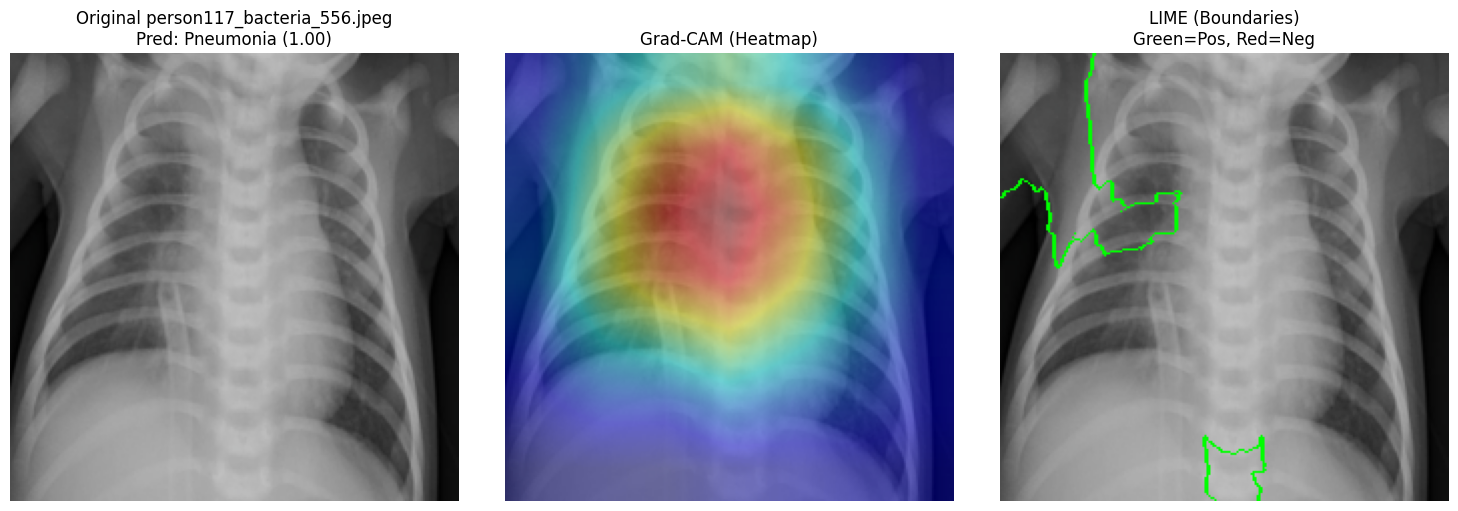

In [39]:
# pick 5 random pneumonia cases
for img_path in sampled_pneumonia:
    print(f"Comparing Grad-CAM and LIME for Pneumonia case: {os.path.basename(img_path)}")
    compare_xai_methods(img_path, model, target_layer, lime_wrapper, class_names, val_test_transform)

# LRP

In [31]:
"""
Layer-wise Relevance Propagation (LRP) for ResNet18
====================================================

LRP is a technique that explains neural network predictions by backpropagating
"relevance" from the output through all layers to the input pixels.

Key LRP Rules:
- LRP-0: Basic rule, simple redistribution
- LRP-epsilon: Adds small epsilon for numerical stability  
- LRP-gamma: Emphasizes positive contributions
- LRP-alpha-beta: Separates positive/negative contributions (α + β = 1)

For this implementation, we use the Captum library which provides robust LRP.
"""

best_path = "best_res18_model1765300376519044.pth"

# Install captum if not available
from captum.attr import LRP

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from torchvision import transforms, models
from torchvision.models import ResNet18_Weights

# ============================================================
# 1. LOAD MODEL
# ============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
model_lrp = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model_lrp.fc = nn.Linear(model_lrp.fc.in_features, 1)
model_lrp.load_state_dict(torch.load(best_path, map_location=device))
model_lrp = model_lrp.to(device)
model_lrp.eval()

print(f"Model loaded from: {best_path}")
print(f"Device: {device}")

# ============================================================
# 2. DATA PREPARATION
# ============================================================
# Transform for input images
transform = val_test_transform if val_test_transform else transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Denormalization for visualization
def denormalize(tensor):
    """Convert normalized tensor back to displayable image"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(tensor.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(tensor.device)
    tensor = tensor * std + mean
    tensor = torch.clamp(tensor, 0, 1)
    return tensor

# ============================================================
# 3. LRP EXPLAINER CLASS
# ============================================================
class LRPExplainer:
    """
    Layer-wise Relevance Propagation explainer for binary classification.
    
    LRP redistributes the prediction score backwards through the network
    to assign relevance scores to each input pixel.
    """
    
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.lrp = LRP(model)
    
    def explain(self, input_tensor, target=None):
        """
        Compute LRP attribution for an input image.
        
        Args:
            input_tensor: Normalized input tensor (1, 3, H, W)
            target: Target class (0 or 1 for binary). If None, uses predicted class.
        
        Returns:
            attribution: LRP relevance scores (H, W)
        """
        input_tensor = input_tensor.to(self.device)
        input_tensor.requires_grad = True
        
        # Get prediction if target not specified
        if target is None:
            with torch.no_grad():
                output = self.model(input_tensor)
                target = (torch.sigmoid(output) >= 0.5).long().item()
        
        # Compute LRP attribution
        # For binary classification with single output, target=0 means the output neuron
        attribution = self.lrp.attribute(input_tensor, target=0)
        
        # Sum across channels and convert to numpy
        attr_np = attribution.squeeze().cpu().detach().numpy()
        if attr_np.ndim == 3:
            attr_np = attr_np.sum(axis=0)  # Sum RGB channels
        
        return attr_np
    
    def predict(self, input_tensor):
        """Get model prediction probability"""
        with torch.no_grad():
            output = self.model(input_tensor.to(self.device))
            prob = torch.sigmoid(output).item()
        return prob

# ============================================================
# 4. VISUALIZATION FUNCTIONS
# ============================================================
def visualize_lrp(image_path, explainer, transform, class_names, figsize=(15, 4)):
    """
    Visualize LRP explanation for a single image.
    
    Shows: Original | LRP Heatmap | Positive Relevance | Overlay
    """
    # Load and preprocess image
    img_pil = Image.open(image_path).convert('RGB')
    img_tensor = transform(img_pil).unsqueeze(0)
    
    # Get prediction
    prob = explainer.predict(img_tensor)
    pred_class = class_names[1] if prob >= 0.5 else class_names[0]
    pred_prob = prob if prob >= 0.5 else 1 - prob
    
    # Compute LRP attribution
    attr = explainer.explain(img_tensor)
    
    # Prepare original image for display
    img_display = denormalize(img_tensor.squeeze()).permute(1, 2, 0).cpu().numpy()
    
    # Create figure
    fig, axes = plt.subplots(1, 4, figsize=figsize)
    
    # 1. Original image
    axes[0].imshow(img_display)
    axes[0].set_title(f"Original\nPred: {pred_class} ({pred_prob:.1%})")
    axes[0].axis('off')
    
    # 2. LRP Heatmap (full, blue-white-red)
    max_abs = np.abs(attr).max() + 1e-10
    axes[1].imshow(attr, cmap='bwr', vmin=-max_abs, vmax=max_abs)
    axes[1].set_title("LRP Attribution\n(Red→Pneumonia, Blue→Normal)")
    axes[1].axis('off')
    
    # 3. Positive relevance only (regions supporting the prediction)
    attr_positive = np.maximum(attr, 0)
    axes[2].imshow(attr_positive, cmap='Reds')
    axes[2].set_title("Positive Relevance\n(Supporting prediction)")
    axes[2].axis('off')
    
    # 4. Overlay on original
    attr_norm = (attr - attr.min()) / (attr.max() - attr.min() + 1e-10)
    heatmap = plt.cm.jet(attr_norm)[:, :, :3]
    img_uint8 = (img_display * 255).astype(np.uint8)
    heatmap_uint8 = (heatmap * 255).astype(np.uint8)
    overlay = cv2.addWeighted(img_uint8, 0.6, heatmap_uint8, 0.4, 0)
    axes[3].imshow(overlay)
    axes[3].set_title("LRP Overlay\n(Important regions)")
    axes[3].axis('off')
    
    plt.tight_layout()
    return fig, attr

def plot_lrp_grid(image_paths, explainer, transform, class_names, rows=4, cols=4):
    """
    Plot LRP explanations for multiple images in a grid.
    Each row shows: Original | LRP Heatmap | Overlay
    """
    n_images = min(len(image_paths), rows * cols // 3 * 3)  # Ensure divisible by 3
    n_rows = (n_images + 2) // 3  # 3 columns per image (orig, heatmap, overlay)
    
    fig, axes = plt.subplots(n_rows, 3, figsize=(12, 4 * n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(n_rows):
        if i >= len(image_paths):
            break
            
        img_path = image_paths[i]
        
        # Load and process
        img_pil = Image.open(img_path).convert('RGB')
        img_tensor = transform(img_pil).unsqueeze(0)
        
        # Prediction
        prob = explainer.predict(img_tensor)
        pred_class = class_names[1] if prob >= 0.5 else class_names[0]
        pred_prob = prob if prob >= 0.5 else 1 - prob
        
        # LRP attribution
        attr = explainer.explain(img_tensor)
        
        # Display image
        img_display = denormalize(img_tensor.squeeze()).permute(1, 2, 0).cpu().numpy()
        
        # Column 1: Original
        axes[i, 0].imshow(img_display)
        axes[i, 0].set_title(f"Original\n{pred_class} ({pred_prob:.1%})")
        axes[i, 0].axis('off')
        
        # Column 2: LRP Heatmap
        max_abs = np.abs(attr).max() + 1e-10
        axes[i, 1].imshow(attr, cmap='bwr', vmin=-max_abs, vmax=max_abs)
        axes[i, 1].set_title("LRP Attribution")
        axes[i, 1].axis('off')
        
        # Column 3: Overlay
        attr_norm = (attr - attr.min()) / (attr.max() - attr.min() + 1e-10)
        heatmap = plt.cm.jet(attr_norm)[:, :, :3]
        img_uint8 = (img_display * 255).astype(np.uint8)
        heatmap_uint8 = (heatmap * 255).astype(np.uint8)
        overlay = cv2.addWeighted(img_uint8, 0.6, heatmap_uint8, 0.4, 0)
        axes[i, 2].imshow(overlay)
        axes[i, 2].set_title("Overlay")
        axes[i, 2].axis('off')
    
    plt.suptitle("LRP Explanations for Pneumonia Classification", fontsize=14)
    plt.tight_layout()
    return fig

# ============================================================
# 5. CREATE EXPLAINER AND RUN
# ============================================================
print("\nInitializing LRP Explainer...")
lrp_explainer = LRPExplainer(model_lrp, device)
print("LRP Explainer ready!")

# ============================================================
# 6. EXPLAIN SAMPLE IMAGES
# ============================================================
print("\n" + "="*60)
print("LRP EXPLANATION FOR SAMPLE IMAGES")
print("="*60)

# Test on a few normal and pneumonia images
print("\n--- Normal Samples ---")
if len(normal_pathes) > 0:
    fig, attr = visualize_lrp(normal_pathes[0], lrp_explainer, transform, class_names)
    plt.show()

print("\n--- Pneumonia Samples ---")  
if len(pneumonia_pathes) > 0:
    fig, attr = visualize_lrp(pneumonia_pathes[0], lrp_explainer, transform, class_names)
    plt.show()

print("\n" + "="*60)
print("INTERPRETATION GUIDE:")
print("-" * 60)
print("• Red regions: Increase Pneumonia prediction (evidence FOR disease)")
print("• Blue regions: Decrease Pneumonia prediction (evidence AGAINST disease)")
print("• White regions: Neutral, little influence on prediction")
print("• Bright regions in overlay: Most important for the model's decision")
print("="*60)


FileNotFoundError: [Errno 2] No such file or directory: 'best_res18_model1765300376519044.pth'

LRP Explanations - Normal Cases


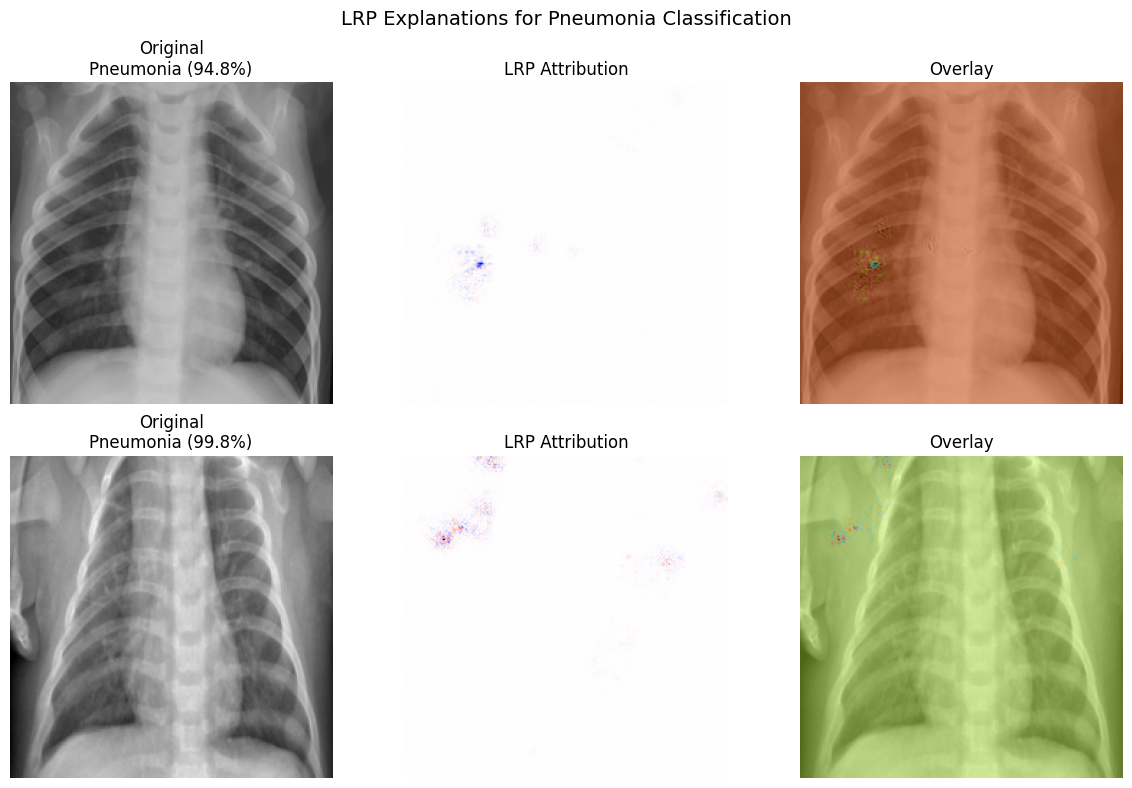


LRP Explanations - Pneumonia Cases


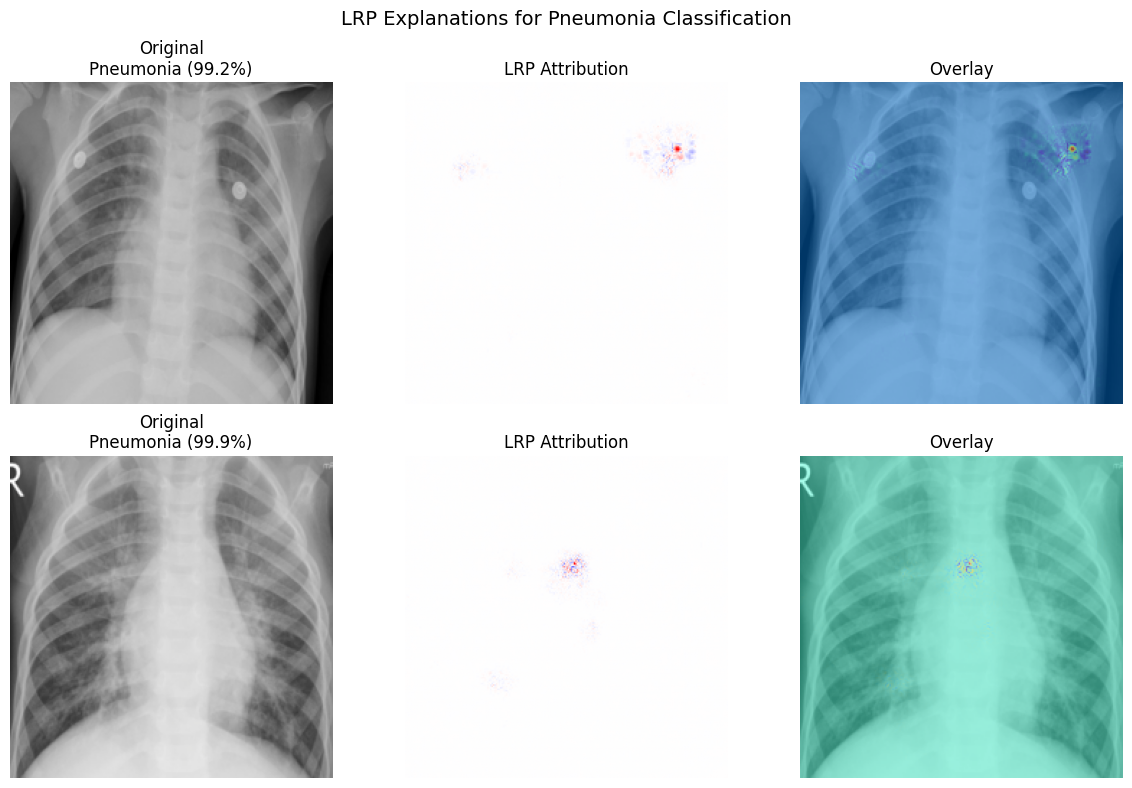

In [113]:
# ============================================================
# LRP VISUALIZATION FOR MULTIPLE IMAGES
# ============================================================

print("="*60)
print("LRP Explanations - Normal Cases")
print("="*60)
fig = plot_lrp_grid(normal_pathes[:6], lrp_explainer, transform, class_names, rows=6)
plt.show()

print("\n" + "="*60)
print("LRP Explanations - Pneumonia Cases")  
print("="*60)
fig = plot_lrp_grid(pneumonia_pathes[:6], lrp_explainer, transform, class_names, rows=6)
plt.show()


## Summary: Comparison of XAI Methods

| Method | Type | Pros | Cons |
|--------|------|------|------|
| **CAM** | Gradient-based | Fast, architecture-specific | Requires GAP layer, coarse resolution |
| **LIME** | Perturbation-based | Model-agnostic, interpretable | Slow, randomness in explanations |
| **SHAP** | Perturbation-based | Theoretically grounded, model-agnostic | Computationally expensive |
| **LRP** | Backpropagation-based | Pixel-level detail, principled | Architecture-dependent rules |
